# Dimensionality Reduction

An essential part of our analysis toolkit is **dimensionality reduction**. We can now record from 100s or 1000s neurons, even different parts of a neuron. Visualizing this kind of high-dimensional data (many measurements over time) is difficult. If we could find ways to reduce the dimensionality of this dataset, we might be able to visualize the relationships of the dimensions, and in some cases, might need to to make some analysis algorithms work.

Questions that might arise:
- Is there a way to reduce the dimensionality of this dataset without discarding useful information?
- What do these neurons have in common? Are their signals pretty independent, or can we find a useful summary of their activity?
- Even if it's possible to use encode/decode modeling to find task-relevant signals, is that the main thing the neural population is computing about? Can we extract the most important signals driving the population's activity?
- A related, but distinct, question arises when studying large-scale recordings of other biological properties of cells. Dimensionality reduction is a critical tool used for simplifying recordings of cell gene expression.

Example: Consider modeling the propagation of electric charge down an axon. While the axon resides in a 3-dimensional space, we can still make useful predictions about charge propagation by considering the axon [a cable](https://en.wikipedia.org/wiki/Cable_theory). So, instead of being concerned with how charge propagates in 3 dimensions, we can simply focus on the dimension that corresponds to position along the axon.

# An example: Simplifying a neural dataset

Let's say we have a dataset that we represent as a matrix $X$ of size $m \times n$, where $m$ is the number of samples we have (say, number of recorded neurons) and $n$ is the number of features we have (say, time points of recorded neural activity). We're trying to summarize this data, collapsing across neurons to find the common patterns across their activity.

![](images/neuron_spike_hist.png)

In this (synthetic) example, it's clear that we could summarize the neurons by taking the average timecourse and not lose too much detail! But how can we quantify how much detail we are capturing? And what if we want to do better than the average? Dimensionality reduction is a broad range of methods that all aim to quantitatively approach this problem.

Data was generated by using Brian, a neural simulation library. Code was adapted from [Wikipedia](https://en.wikipedia.org/wiki/Brian_(software)).

# Linear projection

In this notebook, we'll focus on a simple case for dimensionality reduction by using **linear projection** from the high-dimensional space to the low-dimensional space. We'll start by looking at linear projections for a single vector.

Some definitions

- The **length**, **norm**, or **$L^2$ norm** of a vector $z$ is $\|z\|_2=\sqrt{ z^T z }=\sqrt{ \sum_i z_i^2 }$. We often work with the squared norm, $\|z\|_2^2=z^Tz=\sum_i z_i^2$.
- A **unit vector** $z$ has length 1, so $\|z\|_2=1$. This also means $z^Tz=1$, which we often use when simplifying equations.

Let's start with a vector $x$ that we want to project onto a unit vector $w$. What's the best approximation of our original vector that we can make by using $w$? We'll formalize this by looking for a weight $c$ that we use to scale $w$, making sure it minimizes the approximation error. We quantify the error of our approximate by summing the square of the residuals:

$$
\mathcal{L}(c) = \|x - cw\|_2^2
$$

And we aim to minimize this loss, so our optimization objective is

$$
\arg \min_c \mathcal{L}(c)
$$

We'll find this minimum by taking a derivative of our loss, and solving for our approximation. We'll start by expanding the norm, and then simplifying.

$$
\begin{align}
\mathcal{L}(c) &= \|x - cw\|_2^2 \\
&= (x - cw)^T(x - cw) \\
&= x^Tx - 2 c w^T x + c^2 w^T w \\
&= x^Tx - 2 c w^T x + c^2 & \text{ Since } w^Tw =1 \\
\end{align}
$$

Now, let's take the derivative of our loss. We don't need special handling of the vectors in this expression because they evaluate to scalars and are independent of $c$.

$$
\begin{align}
\frac{d \mathcal{L}(c)}{dc}
&= \frac{d}{dc} \left[ x^Tx - 2 c w^T x + c^2 \right] \\
&= - 2 w^T x + 2 c \\
\end{align}
$$

Finally, we set the derivative to 0 and solve for the best weight $c^*$.
$$
\begin{align}
0 &= - 2 w^T x + 2 c^* \\
w^T x &= c^* \\
\end{align}
$$

So, the best weight $c^*$ to approximate $x$ in terms of $w$ is the dot product of the two vectors, $c^*=x^Tw$, which makes the best approximation $c^*w = x^T w w$. Geometrically, this makes sense, as we'll see.

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg')

x=array([1, 1]) w=array([0.98058068, 0.19611614]) c=1.1766968108291043 c*w=array([1.15384615, 0.23076923]) residual=array([-0.15384615,  0.76923077]) w@residual=-1.3296141180461136e-16


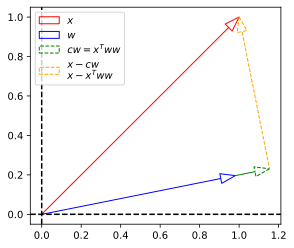

In [2]:
kw = dict(head_width=5e-2, length_includes_head=True, fill=False, width=1e-8)
plt.subplots(figsize=(4.5, 4))

origin = np.array([0, 0])

w = np.array([5, 1])
w = w / np.linalg.norm(w)

x = np.array([1, 1])

plt.arrow(*origin, *x, label='$x$', color='r', **kw)

plt.arrow(*origin, *w, label='$w$', color='b', **kw)

c = x @ w

plt.arrow(*w, *(c*w - w), label='$cw=x^Tww$', color='g', linestyle='--', **kw)

residual = x - c * w
plt.arrow(*(c*w), *(residual), label='$x-cw$\n$x - x^Tww$', color='orange', linestyle='--', **kw)

print(f'{x=} {w=} {c=} {c*w=} {residual=} {w@residual=}')

plt.legend(loc='upper left')
plt.axis('equal')

plt.axhline(0, ls='--', c='k')
plt.axvline(0, ls='--', c='k')

*Exercise: Prove that the residual $x - x^Tww$ is orthogonal to $w$, by showing that $w^T(x - x^Tww)=0$*.

*Solution*:

$$
\begin{align}
w^T(x - x^Tww) &= w^Tx - x^Tw w^Tw \\
&= w^Tx - x^Tw \\
&= 0 \\
\end{align}
$$

## Projecting a matrix

Now that we understand how to project a vector, we'll go over some notation for projecting a matrix.
If we have some matrix $X$ of size $m \times n$ and some unit vector $w$ of size $n$, we can project each row of $X$, $X_{i:}$, onto $w$. The projection for every row is $X_{i:}^T w$, and best approximation is $X_{i:}^T w$. We can write this for the entire matrix, with projections as $Xw$ and approximation as $Xww^T$. Notice in the approximation $Xww^T$ that $Xw$ is a vector of size $m$, and we are multiplying by $w^T$, which is an **outer product**, which results in a matrix of size $m \times n$.

Now, we visualize the projection and approximation of a dataset, borrowing figures from [Alex Williams' blog post on PCA](http://alexhwilliams.info/itsneuronalblog/2016/03/27/pca/). On the left you can see the original dataset, in the middle the vector we project onto ("Component") and projections ("Loadings", $Xw$) of each row of the dataset, and on the right the approximated, or reconstructed, dataset $Xww^T$.

<img src="images/aw-rank1.png" width="80%" />

# Choosing a vector for projection

We now understand how to project a vector and matrix onto a unit vector. Now, we briefly touch on how to choose a vector. We'll choose one that is effective at approximating our original dataset, and we'll measure that by the squared error with our original dataset.

$$
\begin{align}
\mathcal{L}(w) &= \sum_i \| X_{i:}^T w w - X_{i:} \|_2^2 \\
\end{align}
$$

Our optimization objective:

$$
\begin{align}
\arg \min_w \mathcal{L}(w) \\
\text{s.t.} \|w\|=1
\end{align}
$$

Now, let's rearrange the terms in $\mathcal{L}(w)$.

$$
\begin{align}
\mathcal{L}(w) &= \sum_i \| X_{i:}^T w w - X_{i:} \|_2^2 \\
&= \sum_i (X_{i:}^T w w - X_{i:})^T (X_{i:}^T w w - X_{i:}) \\
&= \sum_i (X_{i:}^T w)^2 w^T w - 2 (X_{i:}^T w)^2 + X_{i:}^T X_{i:} \\
&= \sum_i X_{i:}^T X_{i:} - (X_{i:}^T w)^2  & \text{ Since } w^Tw=1 \\
&= \sum_i \| X_{i:} \|^2_2 - (X_{i:}^T w)^2
\end{align}
$$

The first term in that sum is independent of $w$, so it won't influence our results. So let's look a little more at that second term. We can actually rewrite this sum of squared items as a dot product. We can do this because $X_{i:}^T w$ is the same thing as $(Xw)_{i:}$ which makes it possible to write a simple matrix version of this term.

$$
\begin{align}
\sum_i (X_{i:}^T w)^2 = \sum_i (Xw)^2_{i:} = (Xw)^T Xw = \| Xw \|_2^2
\end{align}
$$

This expression looks like the **variance** of our projection, which we'll talk more about now. For some vector $z$ of size $m$ and mean $\mu_z$, the variance is $Var(z) = \frac{1}{m} \sum_i \left(z_i - \mu_z\right)^2$. If you're not familiar, the main idea behind the variance is we want to see how much the data varies around its mean, which we express as an average of the squared error from the mean $(z_i - \mu_z)^2$. If this number is small, then the data is pretty well-described by the mean (since on average $(z_i-\mu_z)^2$ is small); if the variance is large, then there are large deviations $(z_i-\mu_z)^2$ from the mean. If we assume vector $z$ is centered so $\mu_z=0$ (we can accomplish this by subtracting the mean beforehand), then this expression simplifies to

$$Var(z)=\frac{1}{m} \sum_i z_i^2 = \frac{1}{m} z^T z =\frac{1}{m} \|z\|_2^2$$

Going back to our loss function, the variance of the projections, $Var(Xw)=\frac{1}{m} \|Xw\|_2^2$, is proportional to the term $\| Xw \|_2^2$. So, we can interpret our loss as minimizing squared error or, equivalently, as maximizing the variance of the projected data.

Here's a visual proof of this relationship, from [Alex William's blog post](http://alexhwilliams.info/itsneuronalblog/2016/03/27/pca/).

![xx](images/aw-projection_intuition.png)

# Principal Components Analysis

With those pieces in place, we can talk about **Principal Components Analysis** (PCA).
In PCA, we look for orthogonal unit vectors (that we call Principal Components, or PCs) that capture the most variance when our dataset is projected onto them.

When two vectors are **orthogonal**, they are perpendicular (at right angles) to each other. This also means the length of the projection of one onto another is 0, so two vectors $a$ and $b$ are orthogonal when $a^Tb=0$. So each of our PCs will point in different, perpendicular directions that best capture the data.

<!-- Now I'll briefly define **variance**. For some vector $z$ of size $m$ and mean $\mu_z=\frac{1}{m} \sum_i z_i$, the variance is $Var(z) = \frac{1}{m} \sum_i \left(z_i - \mu_z\right)^2$. If you're not familiar with this quantity, the main idea is we want to see how much the data varies around its mean, which we express as an average of the squared error from the mean $(z_i - \mu_z)^2$. If this number is small, then the data is pretty well-described by the mean (since on average $(z_i-\mu_z)^2$ is small); if the variance is large, then there are large deviations $(z_i-\mu_z)^2$ from the mean. If we assume vector $z$ is centered so $\mu_z=0$ (we can accomplish this by subtracting the mean beforehand), then this expression simplifies to -->
<!-- $$Var(z)=\frac{1}{m} \sum_i z_i^2 = \frac{1}{m} z^T z =\frac{1}{m} \|z\|_2^2$$ -->
<!-- because of the definition of the $L^2$ norm $\|z\|_2=\sqrt{ z^T z }=\sqrt{ \sum_i z_i^2 }$. -->

<!-- Now, let's formalize how we'll **project our dataset** onto these PCs. If we have some matrix $X$ of size $m \times n$ and some unit vector $w$ of size $n$, we can project each row of $X$ (denoted $X_{i:}$) onto $w$; the result for every row is the projection $(X_{i:} w) w$ which we can write for the entire matrix as $(Xw)w^T$. I'll note here that the projection of $X_{i:}$ onto $w$ is the the best approximation of $X_{i:}$ that we can make solely by scaling $w$ (might be worth proving / convincing yourself of this). So, when we project our dataset $X$ onto $w$, we are forming the best approximation we can that is solely in terms of $w$. -->
<!-- To assess how good this choice of $w$ is, we will simply analyze the variance of the norms of these projections. First, we'll form a vector of size $m$ containing the projection norm $X_{i:} w$ for each row of $X$, which we can simplify write as a matrix-vector product $Xw$. Then we take the variance of those projection norms $Var(Xw)$. An alternative way to select PCs might be to penalize the error of our approximation. It turns out that penalizing the squared error of the approximation is equivalent to maximizing the variance of our projection norms! Check out details and a proof [here](http://alexhwilliams.info/itsneuronalblog/2016/03/27/pca/). -->

<!-- Now we can think of our PCs as good ways to approximate our dataset, since they are directions that explain our dataset's variance, or minimize our dataset's error after approximation. -->
Using our above definitions, we'll start to look for our first PC, the direction of highest variance in our dataset. To find the second PC, we'll **orthogonalize** our data with respect to our first PC $w$; so we'll subtract out the reconstruction of our dataset $X$ in terms of $w$. Each row will be $X_{i:} - (X_{i:}^T w) w$, which we can also write for the entire matrix as $X-(Xw)w^T$. We'll generalize this for the rest of the PCs by iterating this procedure, orthogonalizing with respect to all previous eigenvectors in order to find the next one.


# Our first PC

Let's find the first PC for our dataset! Summarizing the above, we want to find a PC $w$ of size $n$ in the direction of highest variance of our dataset $X$. We'll do this by finding a $w$ that maximizes $Var(Xw)$, the variance of the data $X$ projected onto $w$. So, our optimization objective is

$$\arg \max_w \frac{1}{m}\|Xw\|^2_2$$

Here's a randomly generated 2D dataset:

(20, 2)


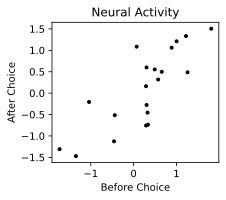

In [3]:
# First, randomly generate data
np.random.seed(42)
X = np.random.multivariate_normal(np.array([0, 0]), np.array([[1, .85], [.85, 1]]), size=20)
print(X.shape)

# Plot data
f, ax = plt.subplots(1, 1, figsize=(3, 3))
ax.plot(*X.T, '.k')
ax.set(
    aspect='equal',
    title='Neural Activity',
    xlabel='Before Choice',
    ylabel='After Choice',
);


We'll pretend this is a dataset recording from some neurons during trials of a task. We'll assume it's some kind of decision making task where we've recorded from neurons before and after some choice. So, every point represents a single neuron, with the axis values corresponding to neural activity before and after choice. From a quick look, it seems like the neurons all exhibit a particular motif of activity, where their activity before and after choice are well-correlated.

So, let's do a PCA! We'll build this one up from scratch. Each dimension has mean of roughly zero, so we'll skip centering. We'll define the variance of a vector, and do grid search to find the best one. In grid search, we enumerate possibilities and select the best, so we'll take the vector in each direction, compute the variance, and report the best.

In [4]:
# First we define a function for the variance.
def Var(z):
    return (z.T@z)/z.shape[0]

# For each direction, we'll define the vector $w$ and compute the $Var(Xw)$.
ws = []
vars = []
for theta in np.arange(0, 2*np.pi, np.pi/16):
    w = np.array([np.sin(theta), np.cos(theta)])
    ws.append(w)
    vars.append(Var(X@w))

# Now we'll find the best one.
best = np.argmax(vars)
pc1 = ws[best]
print('Best vector', pc1, 'has Var()', vars[best])

Best vector [-0.70710678 -0.70710678] has Var() 1.435179832557378


Here we can visualize the variance of each possible PC, with length and color darkness denoting the variance:

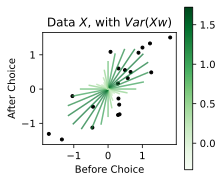

In [5]:
# Plot data
f, ax = plt.subplots(1, 1, figsize=(3, 3))
ax.plot(*X.T, '.k')
ax.set(
    aspect='equal',
    xlabel='Before Choice',
    ylabel='After Choice',
    title='Data $X$, with $Var(Xw)$'
)
sm = matplotlib.cm.ScalarMappable(
    # 0.5 is a hack here to make our colors stand out
    norm=matplotlib.colors.Normalize(vmin=min(vars)-0.5, vmax=max(vars)*1.2),
    cmap=plt.get_cmap('Greens'))
f.colorbar(sm)

for w, var in zip(ws, vars):
    ax.plot([0, var*w[0]], [0, var*w[1]], c=sm.to_rgba(var), alpha=0.7)

# The second PC

We want our second PC to be orthogonal to the first. Since we only have 2 dimensions, that is enough to define our second PC. However, we'll go through the process briefly since it's useful for thinking about data with more dimensions.

First, we'll project our data to the 1st PC. Below, you can see the PC (black line), original data (black points), and projected data (red points). To compute the projection, we first find the length of the projection for each data point $Xw$, then use that length to scale the principal component. So, the red points are $(Xw)w^T$. We can think of them as the best 1-dimensional reconstruction of the original data.

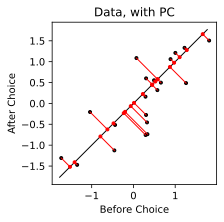

In [6]:
# Plot data
f, ax = plt.subplots(1, 1, figsize=(3, 3))
ax.plot(*X.T, '.k')
ax.set(
    aspect='equal',
    xlabel='Before Choice',
    ylabel='After Choice',
    title='Data, with PC'
)

lim = 2.5
ax.plot([-lim*pc1[0], lim*pc1[0]], [-lim*pc1[1], lim*pc1[1]], '-k', lw=1)

for el in X:
    loading = el @ pc1
    elproj = loading * pc1
    plt.plot([el[0], elproj[0]], [el[1], elproj[1]], '-r', lw=1)
    plt.plot(elproj[0], elproj[1], '.r')#, fillstyle='none')

Since our 2nd PC needs to be orthogonal to the first, we'll subtract the projected dataset from the original, so we'll find the principal component of $X-(Xw)w^T$. First we'll visualize the data without the first PC.

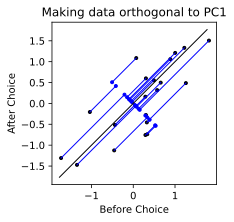

In [7]:
# We define X without first PC
XwithoutPC1 = X - (X@pc1)[:, None] * pc1[None, :]

# Plot data
f, ax = plt.subplots(1, 1, figsize=(3, 3))
ax.plot(*X.T, '.k')
ax.plot(*XwithoutPC1.T, '.b')
ax.set(
    aspect='equal',
    xlabel='Before Choice',
    ylabel='After Choice',
    title='Making data orthogonal to PC1'
)

lim = 2.5
ax.plot([-lim*pc1[0], lim*pc1[0]], [-lim*pc1[1], lim*pc1[1]], '-k', lw=1)

for el, elproj in zip(X, XwithoutPC1):
    plt.plot([el[0], elproj[0]], [el[1], elproj[1]], '-b', lw=1)

Now, we'll do grid search to find our 2nd PC.

In [8]:
# For each direction, we'll define the vector $w$ and compute the $Var(Xw)$.
ws = []
vars = []
for theta in np.arange(0, 2*np.pi, np.pi/16):
    w = np.array([np.sin(theta), np.cos(theta)])
    ws.append(w)
    vars.append(Var(XwithoutPC1@w))

# Now we'll find the best one.
best = np.argmax(vars)
pc2 = ws[best]
print('Best vector', pc2, 'has Var()', vars[best])

Best vector [ 0.70710678 -0.70710678] has Var() 0.16351933703794586


We'll take a look now at the data without the first PC and see what the best second PC is.

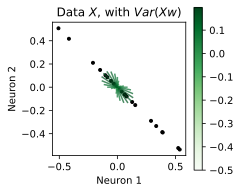

In [9]:
# Plot data
f, ax = plt.subplots(1, 1, figsize=(3, 3))
ax.plot(*XwithoutPC1.T, '.k')
ax.set(
    aspect='equal',
    xlabel='Neuron 1',
    ylabel='Neuron 2',
    title='Data $X$, with $Var(Xw)$'
)

sm = matplotlib.cm.ScalarMappable(
    norm=matplotlib.colors.Normalize(vmin=min(vars)-0.5, vmax=max(vars)*1.2),
    cmap=plt.get_cmap('Greens'))
f.colorbar(sm)

for w, var in zip(ws, vars):
    ax.plot([0, var*w[0]], [0, var*w[1]], c=sm.to_rgba(var), alpha=0.7)

To find other PCs (in a higher-dimensional dataset), you'd simply repeat the steps above. In practice, instead of grid search you'll use methods like SVD, eigendecomposition, or a library that does PCA itself, but we hope this exposition will help you understand what those methods are producing.

*Exercise: Pick up a 3D object near you. Assuming a dataset consisting of a sample of the points on its surface, what are its PCs?*

# Theory: Eigendecomposition

Now, we'll introduce some theory to connect PCA to eigendecomposition.

Eigendecomposition is a way of breaking a matrix down into a sort of canonical representation. The eigendecomposition of a square matrix consists of **eigenvectors** and **eigenvalues**. They have the special property that multiplying a matrix $M$ of size $n \times n$ by one of its unit-length eigenvectors $v_i$ of size $n$ results in the eigenvector scaled by its scalar eigenvalue $\lambda_i$, so

$$
M v_i = \lambda_i v_i
$$

Since this trivially holds for vectors of all zeros, we exclude them from our definition. If our matrix can be decomposed into $n$ linearly independent eigenvectors, then we can express our matrix solely in terms of them and their corresponding eigenvalues. We let $V$ be a matrix where each column is an eigenvector, so $V_{:i}=v_i$. We also let $\Lambda$ be a diagonal matrix with the eigenvalues on the diagonal, so $\Lambda_{ii}=\lambda_i$. Then we can write

$$
MV = V \Lambda
$$
$$
M = V \Lambda V^{-1}
$$

We can think of these eigenvectors as defining a new basis for our matrix $M$. Importantly, this new basis can act as a canonical representation for the matrix that's invariant to rescaling and rotation about the origin. Curiously, it winds up relating to the problem we're trying to solve with PCA, which we'll get into in the next section.

If our eigenvalues are distinct and we sort our eigenvectors by eigenvalue, then we can come up with a unique and canonical way to represent our dataset. We won't always find real-valued eigenvalues and eigenvectors, though if our matrix is real and symmetric we will! A key property of eigendecomposition is that the number of linearly independent eigenvectors corresponds to the rank of the matrix (might be good to think about why this is true).

A typical exposition for eigendecomposition might describe the characteristic polynomial of the matrix $M$, or bring up determinants. You can use them to solve for the eigendecomposition of small matrices, though we typically use other methods for large matrices. I'll close this section out by defining the determinant of a matrix in terms of eigenvalues:

$$det(M) = \prod_i \lambda_i$$

For matrices with fewer eigenvectors than their size, we define the remaining eigenvalues as $0$. So, we know that a full-rank matrix has as many eigenvectors as its size and also has a non-zero determinant.

You might at this point wonder what the determinant _is_. One way to think of it is as a sort of geometric volume of the matrix. Here's a rough argument: In an eigendecomposition we express our matrix $M= V \Lambda V^{-1}$. To keep this argument simple, we'll just consider the case when our matrix is full-rank, so $V^{-1}=V^T$, which means that both $V$ and $V^T$ have unit-length columns. If our data has different variances along its PCs then any stretching in those dimensions must be the result of $\Lambda$, since the PCs are all unit length. So, we can think of our eigenvalues as stretching along our PCs, so their product is a kind of geometric volume for our matrix. For more along this line of exposition, check out the [Deep Learning book's linear algebra section on eigendecomposition](https://www.deeplearningbook.org/contents/linear_algebra.html). I've also heard [3blue1brown has a great exposition on this too](https://www.youtube.com/watch?v=Ip3X9LOh2dk).

# Connecting PCA to eigendecomposition

*In this section, we'll make a formal connection between PCA and eigendecomposition. I'll show that we can get the PCs of $X$ from an eigendecomposition of the covariance $cov(X)$.*

Recall our optimization objective to find our top PC $w$, with $\|w\|_2=1$:

$$\arg \max_w \frac{1}{m}\|Xw\|^2_2$$

Note that $\frac{1}{m}\|Xw\|^2_2 = \frac{1}{m}w^TX^TXw = w^T cov(X) w$, since the covariance of a matrix $X$ of size $m \times n$ is $cov(X) = \frac{1}{m} X^T X$. Now, we can rewrite our optimization objective as:

$$\arg \max_w w^T cov(X) w$$

Since $cov(X)$ is symmetric (could be good to convince yourself of this), we know it has an eigendecomposition with eigenvectors $v_1, \dots, v_n$ and eigenvalues $\lambda_1, \dots, \lambda_n$. For now, let's choose an arbitrary eigenvector as our $w$, so we'll let $w=v_i$, so $w^T cov(X) w = v_i^T cov(X) v_i$. From the definition of eigenvectors, we know that $cov(X) v_i = \lambda_i v_i$, so we can simplify this further

$$
\begin{align}
v_i^T cov(X) v_i &= v_i^T \lambda_i v_i \\
&= \lambda_i v_i^T v_i \\
&= \lambda_i & \text{ Since } v_i^T v_i = 1 \\
\end{align}
$$

Having simplified things, we can rewrite our optimization objective as

$$\arg \max_{v_i} \lambda_i$$

Since the first eigenvector $v_1$ has the largest eigenvalue $\lambda_1$, we should choose it as our first PC! But wait! At the beginning of this proof, we assumed our PC would be one of our eigenvectors. Any vector $w$ can be expressed as a linear combination of our eigenvectors, so is there a chance that some other linear combination of our eigenvectors can explain more variance? While a proof of this is outside the scope of today's material, you can show that the $v_1$ actually explains the most variance (Wikipedia has a proof that I particularly like that proves this for a more general class of problem called the [Rayleigh Quotient](https://en.wikipedia.org/wiki/Rayleigh_quotient#Formulation_using_Lagrange_multipliers)).

Just like we repeated the process to find successive PCs above, you can do the same here and will notice that the best second PC is $v_2$, the third $v_3$, etc. **So, the eigenvectors from eigendecomposition of the covariance of $X$, $cov(X)$, are the PCs of $X$.**

# In Practice

The simplest way to compute a PCA in practice might use some library that solves the problem. For most practical uses, you might want to use `sklearn`'s version, which recovers similar values are above.

In [10]:
import sklearn.decomposition
pca = sklearn.decomposition.PCA()
pca.fit(X)

for i in range(2):
    print('PC', pca.components_[i], 'Var()', pca.explained_variance_[i])

PC [-0.69448318 -0.71950894] Var() 1.4507271870129048
PC [-0.71950894  0.69448318] Var() 0.16095171311080222


We touched on the topic of mean-centering above; it's important for making sure your PCs are interpretable. If your data isn't centered, the first PC may at times be the dataset's average, but there enough caveats (mentioned in this great [StatsExchange post](https://stats.stackexchange.com/a/130565)) that it's worth simply mean-centering yourself.

Thankfully, `sklearn` does mean-centering by default! Check out the [documentation here](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html), relevant piece is:

> Linear dimensionality reduction using Singular Value Decomposition of the data to project it to a lower dimensional space. The input data is centered but not scaled for each feature before applying the SVD.

We'll briefly note the relationship between PCA and Singular Value Decomposition later on, but I think it's worth appreciating that `sklearn`'s PCA is really simple. [Here's the full code](https://github.com/scikit-learn/scikit-learn/blob/0fb307bf39bbdacd6ed713c00724f8f871d60370/sklearn/decomposition/_pca.py#L450-L464), which can be boiled down to these lines:

```python
X -= np.mean(X, axis=0)
_, singular_values_, components_ = linalg.svd(X, full_matrices=False)
explained_variance_ = (singular_values_ ** 2) / (n_samples - 1)
```

## How many components to use?

Depends on what you want to do with them! Some try to choose components that are less likely to be noise, by comparing the relative amount of variance explained by each PC. This sort of choice winds up being heuristic; you might look for a component that explains much less than prior ones, or the components necessary to explain some fixed amout of variance. As Alex Williams notes in [this blog post](http://alexhwilliams.info/itsneuronalblog/2016/03/27/pca/) there are also theoeretically motivated ways to choose the number of components. I'll show an example using a builtin dataset from sklearn.

The largest gap is from the first to second component, but taking the first 6 explains 90% of the variance.

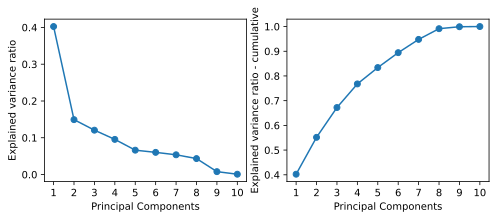

In [11]:
import sklearn.datasets
data = sklearn.datasets.load_diabetes().data
pca = sklearn.decomposition.PCA()
pca.fit(data)
xs = range(1, len(pca.components_)+1)

f, axes = plt.subplots(1, 2, figsize=(8, 3))
axes[0].plot(xs, pca.explained_variance_ratio_, '-o')
axes[0].set_ylabel('Explained variance ratio')
axes[0].set_xlabel('Principal Components')
axes[0].set_xticks(xs)

axes[1].plot(xs, np.cumsum(pca.explained_variance_ratio_), '-o')
axes[1].set_ylabel('Explained variance ratio - cumulative')
axes[1].set_xlabel('Principal Components')
axes[1].set_xticks(xs);

## Reconstruction

Above, we projected our data back to the first PC, making a low-dimensional approximation of our data. What does this look like in higher dimensions? In this section, we'll walk through figures from [Alex Williams' blog post](http://alexhwilliams.info/itsneuronalblog/2016/03/27/pca/). On the left you can see the dataset, in the middle the top PC and loadings of each row of the dataset, and on the right the reconstructed dataset. Clearly an approximation, but not bad!

<img src="images/aw-rank1.png" width="80%" />

Now we'll look at a more complicated dataset. Here's the explained variance ratio for each component. It looks like 3-components should give us a good approximation.

<img src="images/aw-scree.png" width="30%" />

Here's the 3-dimensional approximation.

<img src="images/aw-rank3.png" width="80%" />

We'll close this section out with some code that makes similar plots as the above, making low-dimensional approximations of our datasets.

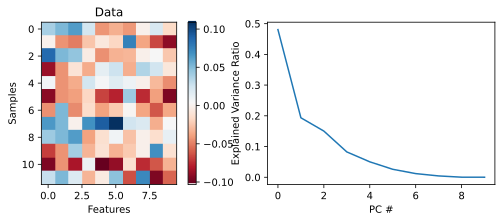

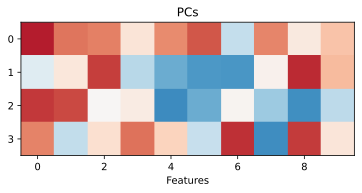

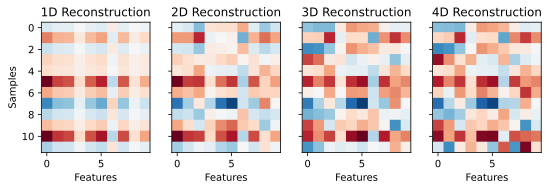

In [12]:
small_data = sklearn.datasets.load_diabetes().data[:12, :10]
kw = dict(vmin=small_data.min(), vmax=small_data.max())

pca = sklearn.decomposition.PCA()
pca.fit(small_data)

cm = plt.get_cmap('RdBu')

f, axes = plt.subplots(1, 2, figsize=(9, 3))
plt.sca(axes[0])
plt.imshow(small_data, cmap=cm, **kw)
plt.title('Data')
plt.xlabel('Features')
plt.ylabel('Samples')
plt.colorbar()

plt.sca(axes[1])
plt.ylabel('Explained Variance Ratio')
plt.xlabel('PC #')
plt.plot(pca.explained_variance_ratio_)

plt.figure()
plt.title('PCs')
plt.xlabel('Features')
lim = max(abs(pca.components_.min()), abs(pca.components_.max()))
plt.imshow(pca.components_[0:4], cmap=cm, vmin=-lim, vmax=lim)

f, axes = plt.subplots(1, 4, figsize=(9, 3), sharex=True, sharey=True)
axes[0].set_ylabel('Samples')
for ndim, ax in zip([1, 2, 3, 4], axes):
    plt.sca(ax)
    recon = np.zeros(small_data.shape)
    for pcidx in range(ndim):
        loading = small_data @ pca.components_[pcidx]
        recon += loading[:, None] * pca.components_[pcidx][None, :]
    plt.imshow(recon, cmap=cm, **kw)
    plt.title('{}D Reconstruction'.format(ndim))
    plt.xlabel('Features')

# How is PCA computed

While we took an optimization approach above, part of PCA's ubiquity and appeal is that it can be efficiently computed using ideas from linear algebra. As you could see from `sklearn`, different linear algebra decompositions can be used to find our PCs.

One of the most common ways to do a PCA is an eigendecomposition of the covariance matrix:

In [13]:
evals, evecs = np.linalg.eig(np.cov(X.T))
for i in range(2):
    print('PC/Eigenvector', evecs[:, i], 'Var()/Eigenvalue', evals[i])

PC/Eigenvector [-0.71950894  0.69448318] Var()/Eigenvalue 0.16095171311080214
PC/Eigenvector [-0.69448318 -0.71950894] Var()/Eigenvalue 1.4507271870129046


Or to take the Singular Value Decomposition (SVD) of the matrix (which is what `sklearn` does).

(A brief aside: SVD can be preferable over eigendecomposition when you have many more features than samples you are trying to do a PCA on. Eigendecomposition requires computing the covariance of the features, so for large numbers of features can be unwieldly. SVD is likely preferable in that case since it can decompose rectangular data, avoiding the large size of the feature covariance matrix. For a great thread on SVD, check out this [twitter thread of Daniela Witten's](https://twitter.com/WomenInStat/status/1285610321747611653))

In [14]:
U, S, VT = np.linalg.svd(X)
for i in range(2):
    print('PC/singular vectors', VT[:, i], 'singular value', S[i], 'Var()', S[i]**2/X.shape[0])

PC/singular vectors [0.70852281 0.70568792] singular value 5.35758330314973 Var() 1.4351849425094387
PC/singular vectors [ 0.70568792 -0.70852281] singular value 1.8083928062557901 Var() 0.1635142270858846


If you're curious about how `np.linalg.svd` or `np.linalg.eig` are computed, you can visit [wikipedia](https://en.wikipedia.org/wiki/Singular_value_decomposition#Calculating_the_SVD) for the gory details. A theme in many implementations is something called [Power Iteration](https://en.wikipedia.org/wiki/Power_iteration), where you take a random vector, multiply it by your data matrix, normalize the result, and repeat. After many iterations, this will give you the eigenvector of your data matrix. Below is an example of computing the first eigenvector using Power Iteration.

In [15]:
w = np.random.uniform(-1, 1, size=2)
print('Random vector', w)
for _ in range(1000):
    w = np.cov(X.T) @ w
    w = w / np.linalg.norm(w)
print('After power iteration', w)

Random vector [0.93916926 0.55026565]
After power iteration [0.69448318 0.71950894]


# Conclusion

We now know how to employ PCA to perform dimensionality reduction! In your exercise, you'll apply this method to understand a dataset (from Russo et al. 2020). There are many approaches to dimensionality reduction in neural data:

- Russo et al. 2020 and [Gallego et al. 2018](https://www.nature.com/articles/s41467-018-06560-z) both simply use PCA.
- An early paper, [Churchland et al. 2012](https://www.nature.com/articles/nature11129) uses a variant of PCA that is designed for time series.
- More complex and modern approaches like [Low et al. 2018](https://www.biorxiv.org/content/10.1101/418939v2) attempt to unravel the structure in neural manifolds; in their case, they flatten out place cell representations into a map.

# Resources
- [Alex Williams' blog post](http://alexhwilliams.info/itsneuronalblog/2016/03/27/pca/) on the topic was remarkably helpful for this line of presentation.
- To formally present eigendecomposition, I relied on the linear algebra review in the [Deep Learning book](https://www.deeplearningbook.org/contents/linear_algebra.html).
- [Daniela Witten's twitter thread on SVD](https://twitter.com/WomenInStat/status/1285610321747611653).
- [Geometric interpretations of PCs](https://www.visiondummy.com/2014/04/geometric-interpretation-covariance-matrix/), something I didn't touch on.
- [A really nice tutorial linked by Alex William](https://www.cs.princeton.edu/picasso/mats/PCA-Tutorial-Intuition_jp.pdf)
- Some Math StackExchange answers proving the connections between eigendecomposition / covariance / PCA. [here's one](https://math.stackexchange.com/questions/23596/why-is-the-eigenvector-of-a-covariance-matrix-equal-to-a-principal-component) and [another](https://math.stackexchange.com/questions/2147211/why-are-the-eigenvalues-of-a-covariance-matrix-equal-to-the-variance-of-its-eige)
- For background, I roughly assume [Eero Simoncelli's notes](https://www.cns.nyu.edu/~eero/NOTES/geomLinAlg.pdf).